In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
def get_bird_data(augmentation=0):
    transform_train = transforms.Compose([
        transforms.Resize(128),
        transforms.RandomCrop(128, padding=8, padding_mode='edge'), # Take 128x128 crops from padded images
        transforms.RandomHorizontalFlip(),    # 50% of time flip image along y-axis
        transforms.ToTensor(),
    ])
    
    transform_test = transforms.Compose([
        transforms.Resize(128),
        transforms.CenterCrop(128),
        transforms.ToTensor(),
    ])
    trainset = torchvision.datasets.ImageFolder(root='train', transform=transform_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
    testset = torchvision.datasets.ImageFolder(root='test', transform=transform_test)
    testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False, num_workers=2)
    
    classes = open("names.txt").read().strip().split("\n")
    
    # Backward mapping to original class ids (from folder names) and species name (from names.txt)
    class_to_idx = trainset.class_to_idx
    idx_to_class = {int(v): int(k) for k, v in class_to_idx.items()}
    idx_to_name = {k: classes[v] for k,v in idx_to_class.items()}
    return {'train': trainloader, 'test': testloader, 'to_class': idx_to_class, 'to_name':idx_to_name}

data = get_bird_data()

torch.Size([8, 3, 128, 128])


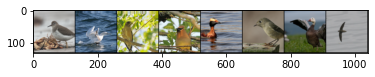

Labels:Spotted Sandpiper (Nonbreeding/juvenile), Northern Gannet (Adult, Subadult), Evening Grosbeak (Female/Juvenile), Cedar Waxwing, Horned Grebe (Breeding), Ruby-crowned Kinglet, Snow Goose (Blue morph), Chimney Swift


In [5]:
dataiter = iter(data['train'])
images, labels = dataiter.next()
images = images[:8]
print(images.size())

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print("Labels:" + ', '.join('%9s' % data['to_name'][labels[j].item()] for j in range(8)))

In [6]:
def train(net, dataloader, epochs=1, start_epoch=0, lr=0.01, momentum=0.9, decay=0.0005, 
          verbose=1, print_every=10, state=None, schedule={}, checkpoint_path=None):
    net.to(device)
    net.train()
    losses = []
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=decay)

    # Load previous training state
    if state:
        net.load_state_dict(state['net'])
        optimizer.load_state_dict(state['optimizer'])
        start_epoch = state['epoch']
        losses = state['losses']

    # Fast forward lr schedule through already trained epochs
    for epoch in range(start_epoch):
        if epoch in schedule:
            print ("Learning rate: %f"% schedule[epoch])
            for g in optimizer.param_groups:
                g['lr'] = schedule[epoch]
    for epoch in range(start_epoch, epochs):
        sum_loss = 0.0

        # Update learning rate when scheduled
        if epoch in schedule:
            print ("Learning rate: %f"% schedule[epoch])
            for g in optimizer.param_groups:
                g['lr'] = schedule[epoch]

       
        for i, batch in tqdm(enumerate(dataloader)):
            inputs, labels = batch[0].to(device), batch[1].to(device)

            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()  # autograd magic, computes all the partial derivatives
            optimizer.step() # takes a step in gradient direction

            losses.append(loss.item())
            sum_loss += loss.item()

            if i % print_every == print_every-1:    # print every 10 mini-batches
                if verbose:
                  print('[%d, %5d] loss: %.3f' % (epoch, i + 1, sum_loss / print_every))
                sum_loss = 0.0

            i += 1
        if checkpoint_path:
            state = {'epoch': epoch+1, 'net': net.state_dict(), 'optimizer': optimizer.state_dict(), 'losses': losses}
            torch.save(state, checkpoint_path + 'checkpoint-%d.pkl'%(epoch+1))
    return losses  

resnet = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=True)
resnet.fc = nn.Linear(512, 555)

losses = train(resnet, data['train'], epochs=5, lr=.01, print_every=10)          

Downloading: "https://github.com/pytorch/vision/archive/v0.6.0.zip" to C:\Users\xubow/.cache\torch\hub\v0.6.0.zip
Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to C:\Users\xubow/.cache\torch\hub\checkpoints\resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 24.4MB/s]
0
1
2
3
4
5
6
7
8
9
[0,    10] loss: 6.552
10
11
12
13
14
15
16
17
18
19
[0,    20] loss: 6.339
20
21
22
23
24
25
26
27
28
29
[0,    30] loss: 6.160
30
31
32
33
34
35
36
37
38
39
[0,    40] loss: 5.995
40
41
42
43
44
45
46
47
48
49
[0,    50] loss: 5.665
50
51
52
53
54
55
56
57
58
59
[0,    60] loss: 5.446
60
61
62
63
64
65
66
67
68
69
[0,    70] loss: 5.247
70
71
72
73
74
75
76
77
78
79
[0,    80] loss: 5.040
80
81
82
83
84
85
86
87
88
89
[0,    90] loss: 4.771
90
91
92
93
94
95
96
97
98
99
[0,   100] loss: 4.605
100
101
102
103
104
105
106
107
108
109
[0,   110] loss: 4.518
110
111
112
113
114
115
116
117
118
119
[0,   120] loss: 4.298
120
121
122
123
124
125
126
127
128
129
[0,  

In [7]:
def predict(net, dataloader, ofname):
    out = open(ofname, 'w')
    out.write("path,class\n")
    net.to(device)
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for i, (images, labels) in enumerate(dataloader, 0):
            if i%100 == 0:
                print(i)
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            fname, _ = dataloader.dataset.samples[i]
            out.write("test/{},{}\n".format(fname.split('/')[-1], data['to_class'][predicted.item()]))
    out.close()

In [8]:
predict(resnet, data['test'], "preds.csv")

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
